In [1]:
from ema_workbench.analysis import prim
from ema_workbench import load_results
from sklearn import preprocessing
from problem_formulation import get_model_for_problem_formulation
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns

In [2]:
ACTOR = "genscen_Overijssel_50000_12-06-2021-02-18-42.tar.gz"

In [3]:
experiments, outcomes = load_results("simulation/generated/" + ACTOR)
dike_model, planning_steps = get_model_for_problem_formulation("Overijssel")
uncertainties = [uncertainty.name for uncertainty in dike_model.uncertainties]
x = experiments[uncertainties]
outcomes_df = pd.DataFrame(outcomes)

In [4]:
outcomes_df.columns.values.tolist()

['Gorssel and Deventer Expected Annual Damage',
 'Gorssel and Deventer Expected Number of Deaths',
 'Gorssel and Deventer Total Costs']

In [5]:
DAMAGE = outcomes_df.columns[0]
DEATHS = outcomes_df.columns[1]
COSTS = outcomes_df.columns[2]

C:\Users\Lisette\anaconda3\envs\adsim\lib\site-packages\ema_workbench\analysis\regional_sa.py:162: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left=x0, right=x1)
C:\Users\Lisette\anaconda3\envs\adsim\lib\site-packages\ema_workbench\analysis\regional_sa.py:162: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left=x0, right=x1)
C:\Users\Lisette\anaconda3\envs\adsim\lib\site-packages\ema_workbench\analysis\regional_sa.py:162: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left=x0, right=x1)
C:\Users\Lisette\anaconda3\envs\adsim\lib\site-packages\ema_workbench\analysis\regional_sa.py:162: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_

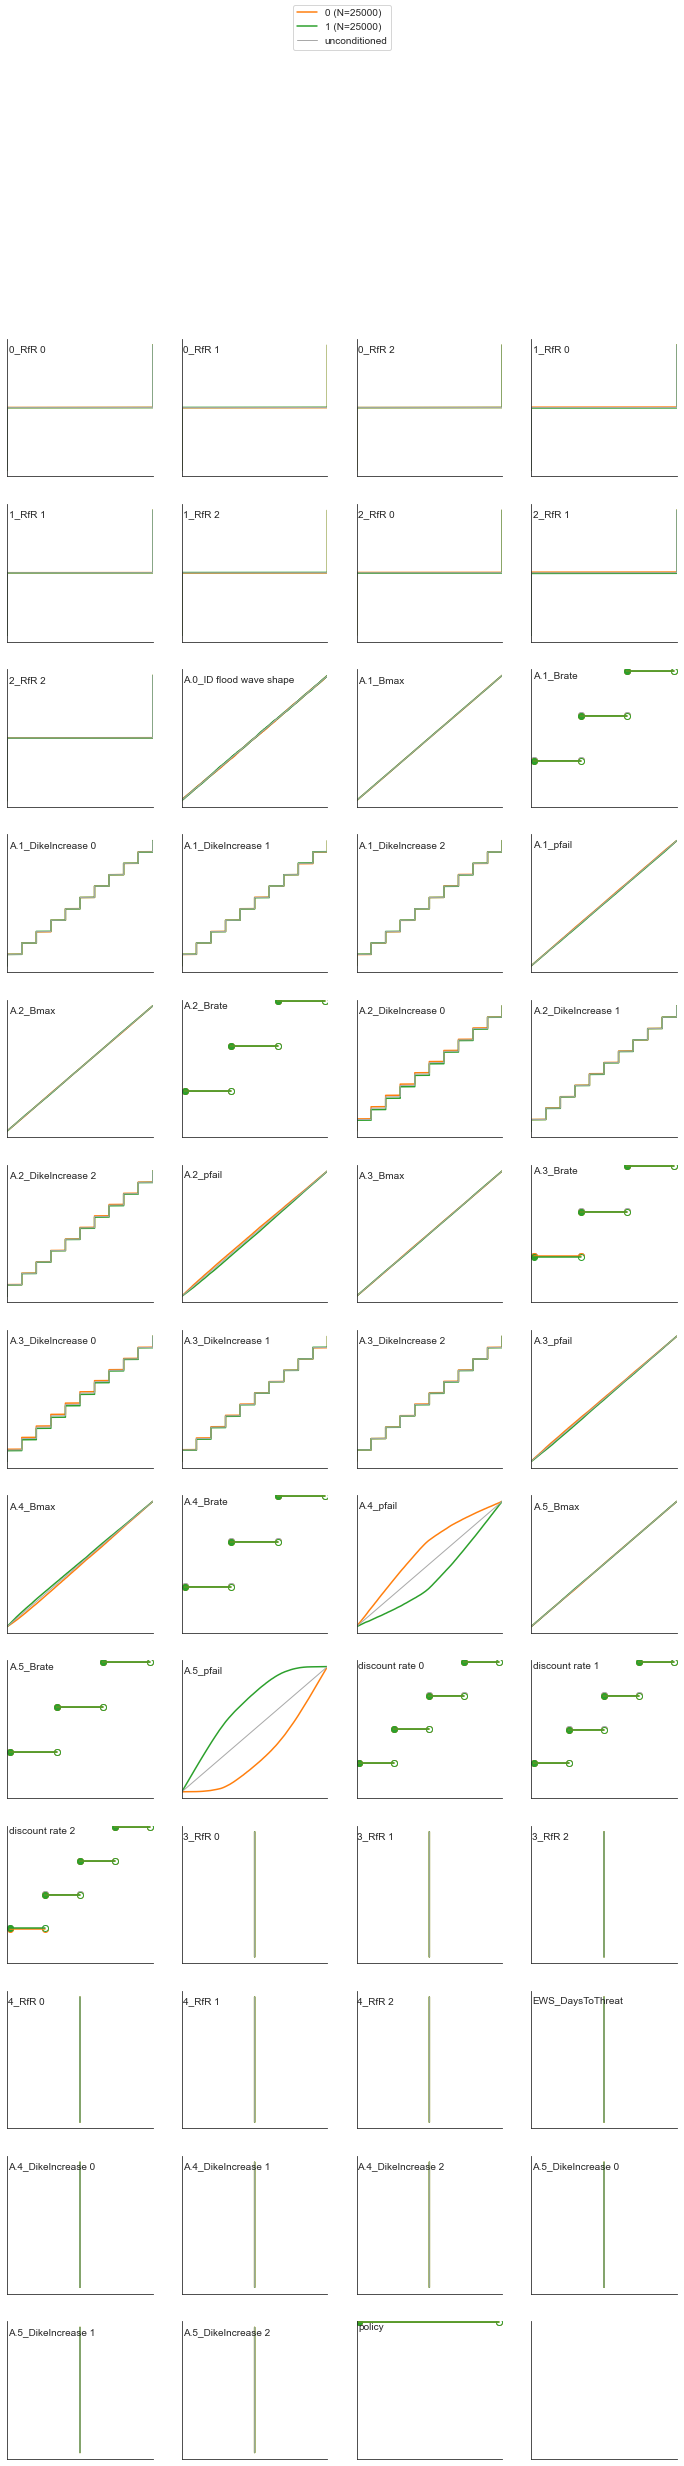

In [6]:
from ema_workbench.analysis import regional_sa
from numpy.lib import recfunctions as rf

sns.set_style('white')

# model is the same across experiments
x = experiments.copy()
x = x.drop('model', axis=1)
y = outcomes[DEATHS] >  np.percentile(a=outcomes_df[DEATHS], q=50)
fig = regional_sa.plot_cdfs(x,y)
sns.despine()
plt.show()

Just as sensitivity analsyis showed, the outcomes are most sensitivie to A.4_pfail and A.5_pfail.

In [7]:
outcomes_df.describe(percentiles=np.arange(0, 1, 0.1))

,Gorssel and Deventer Expected Annual Damage,Gorssel and Deventer Expected Number of Deaths,Gorssel and Deventer Total Costs
count,5.000000e+04,50000.000000,50000.0
mean,2.238156e+08,0.185281,0.0
std,2.662215e+08,0.236627,0.0
min,0.000000e+00,0.000000,0.0
0%,0.000000e+00,0.000000,0.0
10%,3.141319e+07,0.021130,0.0
20%,5.190175e+07,0.030364,0.0
30%,7.143141e+07,0.044249,0.0
40%,9.542010e+07,0.061027,0.0
50%,1.228096e+08,0.073162,0.0


Obviously, without any policies inplace, there also aren't any costs for Overijssel.

In [8]:
prim_algs = {}
percentiles = [40, 90]

def conditional(outcome, q):
    global percentiles
    if q == percentiles[0]:
        return outcomes_df[outcome] < np.percentile(a=outcomes_df[outcome], q=q)
    elif q == percentiles[1]:
        return outcomes_df[outcome] > np.percentile(a=outcomes_df[outcome], q=q)  
            
for q in percentiles:
    prim_algs[q] = {}   
    for outcome in [DAMAGE, DEATHS]:
        prim_algs[q][outcome] = prim.Prim(x,  conditional(outcome, q), threshold=0.8)

In [9]:
boxes = {}
for upperkey in percentiles:
    boxes[upperkey] = {}
    for lowerkey in [DAMAGE, DEATHS]:
        boxes[upperkey][lowerkey] = prim_algs[upperkey][lowerkey].find_box()

40


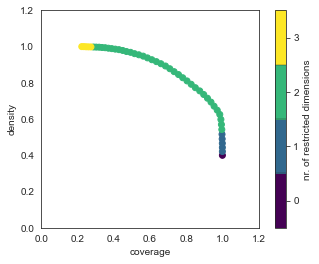

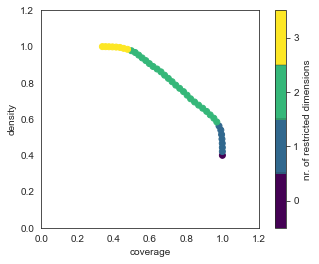

90


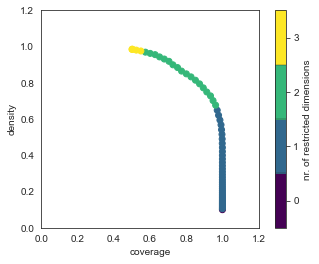

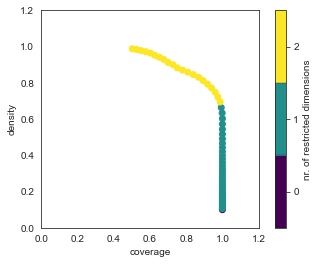

In [10]:
for upperkey, percentile in boxes.items():
    print(upperkey)
    for lowerkey, box in percentile.items():
        box.show_tradeoff()
        plt.show()

# Trying around to find the right box
Only going to epxlore A.5_pfail


## Damage

coverage     0.80475
density     0.810627
id                18
mass          0.3971
mean        0.810627
res_dim            2
Name: 18, dtype: object

            box 18                                          
               min       max                       qp values
A.5_pfail  0.53754  0.999986                     [0.0, -1.0]
A.4_pfail  0.14291  0.999986  [8.157749483849377e-239, -1.0]



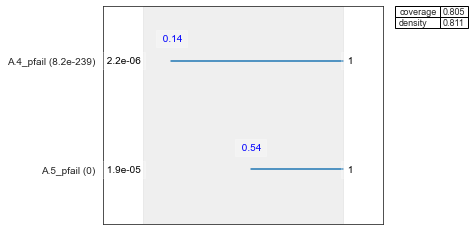

In [11]:
box_id=18
BOX = DAMAGE
boxes[percentiles[0]][BOX].inspect(box_id)
boxes[percentiles[0]][BOX].inspect(box_id, style='graph')
plt.show()

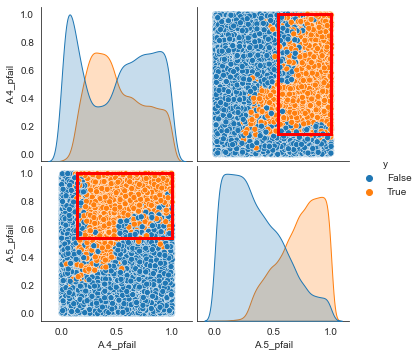

In [12]:
boxes[percentiles[0]][BOX].select(box_id)
boxes[percentiles[0]][BOX].show_pairs_scatter()
plt.show()

In [13]:
lims = boxes[percentiles[0]][BOX].box_lims[box_id]
limits = pd.DataFrame(data={"outcome": ["damage " + str(percentiles[0])], "min": [lims["A.4_pfail"][0]], "max" :  [lims["A.4_pfail"][1]]})

coverage       0.874
density     0.794401
id                43
mass         0.11002
mean        0.794401
res_dim            2
Name: 43, dtype: object

             box 43                                          
                min       max                       qp values
A.5_pfail  0.000019  0.115677                     [-1.0, 0.0]
A.4_pfail  0.049751  0.999986  [1.6662514062707373e-08, -1.0]



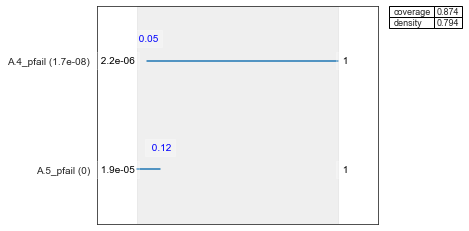

In [14]:
box_id=43
BOX = DAMAGE
boxes[percentiles[1]][BOX].inspect(box_id)
boxes[percentiles[1]][BOX].inspect(box_id, style='graph')
plt.show()

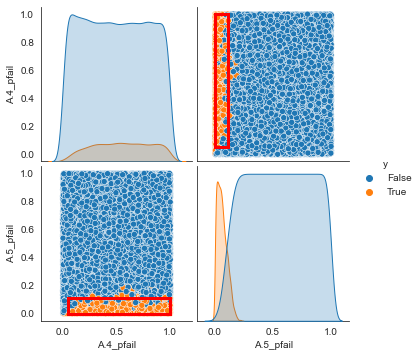

In [15]:
boxes[percentiles[1]][BOX].select(box_id)
boxes[percentiles[1]][BOX].show_pairs_scatter()
plt.show()

In [16]:
lims = boxes[percentiles[1]][BOX].box_lims[box_id]
limits = pd.concat([limits, pd.DataFrame(data={"outcome": ["damage " + str(percentiles[1])], "min": [lims["A.5_pfail"][0]], "max" :  [lims["A.5_pfail"][1]]})], axis=0)

## Deaths

In [17]:
box_id=20
BOX = DEATHS

coverage     0.7224
density     0.80634
id               20
mass        0.35836
mean        0.80634
res_dim           2
Name: 20, dtype: object

             box 20                                          
                min       max                       qp values
A.5_pfail  0.401557  0.999986                     [0.0, -1.0]
A.4_pfail  0.128980  0.727844  [1.0102371683369226e-198, 0.0]



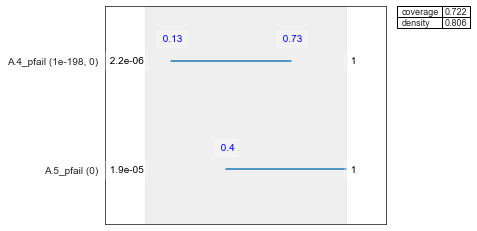

In [18]:
boxes[percentiles[0]][BOX].inspect(box_id)
boxes[percentiles[0]][BOX].inspect(box_id, style='graph')
plt.show()

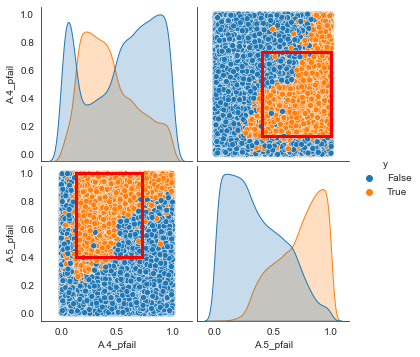

In [19]:
boxes[percentiles[0]][BOX].select(box_id)
boxes[percentiles[0]][BOX].show_pairs_scatter()
plt.show()

In this specific case preprocessing, would have helped a lot. Perhaps it would have reduced dimensionality. Checking it out later in the notebook

In [20]:
lims = boxes[percentiles[0]][BOX].box_lims[box_id]

In [21]:
limits = pd.concat([limits, pd.DataFrame(data={"outcome": ["deaths "+ str(percentiles[0])], "min": [lims["A.5_pfail"][0]], "max" :  [lims["A.5_pfail"][1]]})], axis=0)

In [22]:
box_id=43
BOX = DEATHS

coverage      0.8936
density     0.812216
id                43
mass         0.11002
mean        0.812216
res_dim            2
Name: 43, dtype: object

             box 43                                        
                min       max                     qp values
A.5_pfail  0.000019  0.121759                   [-1.0, 0.0]
A.4_pfail  0.098666  0.999986  [1.57364289090277e-24, -1.0]



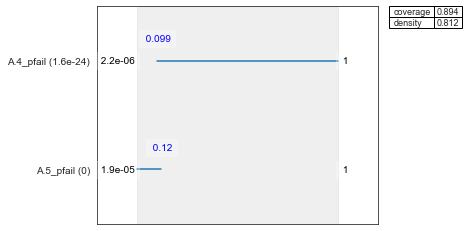

In [23]:
boxes[percentiles[1]][BOX].inspect(box_id)
boxes[percentiles[1]][BOX].inspect(box_id, style='graph')
plt.show()

In [24]:
lims = boxes[percentiles[1]][BOX].box_lims[box_id]

In [25]:
limits = pd.concat([limits, pd.DataFrame(data={"outcome": ["deaths "+ str(percentiles[1])], "min": [lims["A.5_pfail"][0]], "max" :  [lims["A.5_pfail"][1]]})], axis=0)

# Visualisation

In [26]:
limits =limits.reset_index(drop=True)

In [27]:
limits

,outcome,min,max
0,damage 40,0.142910,0.999986
1,damage 90,0.000019,0.115677
2,deaths 40,0.401557,0.999986
3,deaths 90,0.000019,0.121759


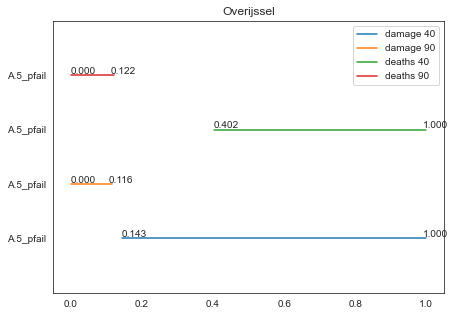

In [28]:
fig = plt.figure(figsize=[7,5])
ax = fig.add_subplot(111)
for index in limits.index:
    plt.plot([limits.loc[index]["min"],limits.loc[index]["max"]], [index,index])
    ax.annotate('{:.3f}'.format(limits.loc[index]["min"]),xy=(limits.loc[index]["min"],index +0.03))
    ax.annotate('{:.3f}'.format(limits.loc[index]["max"]),xy=(limits.loc[index]["max"]-0.01,index +0.03))
ax.grid(False)
ax.set_ylim([-1,4])
plt.legend(limits["outcome"].values)    
plt.yticks([0, 1,2, 3], ["A.5_pfail"]*4)
plt.title("Overijssel")
plt.show()

In [29]:
o_scen = pd.read_csv("simulation/optimisation/Overijssel/selected.csv")

In [30]:
A5_pfail = o_scen["A.5_pfail"]

0.2805006899558374
0.3849391419194088
0.5985661199041477
0.3036545903285859
0.0164616688960415
0.0069755480995318


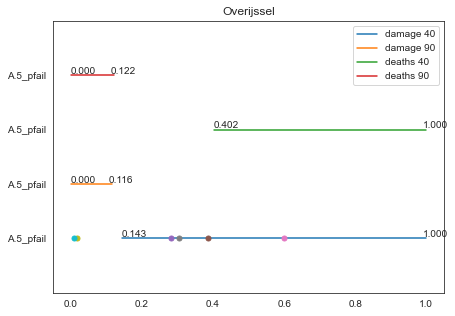

In [31]:
fig = plt.figure(figsize=[7,5])
ax = fig.add_subplot(111)
for index in limits.index:
    plt.plot([limits.loc[index]["min"],limits.loc[index]["max"]], [index,index])
    ax.annotate('{:.3f}'.format(limits.loc[index]["min"]),xy=(limits.loc[index]["min"],index +0.03))
    ax.annotate('{:.3f}'.format(limits.loc[index]["max"]),xy=(limits.loc[index]["max"]-0.01,index +0.03))

for pfail in A5_pfail:
    plt.plot(pfail, 0, markersize=5,  marker='o')
    print(pfail)
    
ax.grid(False)
ax.set_ylim([-1,4])
plt.legend(limits["outcome"].values)    
plt.yticks([0, 1,2, 3], ["A.5_pfail"]*4)
plt.title("Overijssel")
plt.show()

So we have a nice distribution with our scenario selection method! Great. Will continue on this in scen_disco

# With preprocessing

In [32]:
prim_algs = {}
percentiles = [40, 90]

def conditional(outcome, q):
    global percentiles
    if q == percentiles[0]:
        return outcomes_df[outcome] < np.percentile(a=outcomes_df[outcome], q=q)
    elif q == percentiles[1]:
        return outcomes_df[outcome] > np.percentile(a=outcomes_df[outcome], q=q)  
            
for q in percentiles:
    prim_algs[q] = {}   
    for outcome in [DAMAGE, DEATHS]:
        x = experiments.copy()
        x = x.drop('model', axis=1)
        x_numeric = x.select_dtypes(exclude=pd.CategoricalDtype)
        x_categorical = x.select_dtypes(include=pd.CategoricalDtype)
        rotated_experiments, rotation_matrix = prim.pca_preprocess(x_numeric, outcomes_df[outcome] > np.percentile(a=outcomes_df[outcome], q=q))
        rotated_x = pd.concat([rotated_experiments, x_categorical], axis=1)
        rotated_x.columns = x_numeric.columns.tolist() + x_categorical.columns.tolist()
        x = rotated_x
        prim_algs[q][outcome] = prim.Prim(x,  conditional(outcome, q), threshold=0.8)

In [ ]:
boxes = {}
for upperkey in percentiles:
    boxes[upperkey] = {}
    for lowerkey in [DAMAGE, DEATHS]:
        boxes[upperkey][lowerkey] = prim_algs[upperkey][lowerkey].find_box()

In [ ]:
box_id=20
BOX = DEATHS

In [ ]:
boxes[percentiles[0]][BOX].inspect(box_id)
boxes[percentiles[0]][BOX].inspect(box_id, style='graph')
plt.show()

In [ ]:
boxes[percentiles[0]][BOX].select(box_id)
boxes[percentiles[0]][BOX].show_pairs_scatter()
plt.show()

Still 2 dimensions for a density >= 0.8, so marginal improvement, really. Coverage is only slightly better. Preprocessing doesn't help much.